In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

## Cargar datos

In [2]:
# Cargar el archivo TIFF Sentinel 2
file_path = '/Users/ortega/Downloads/clase/train/combinado.tif'
src = rasterio.open(file_path)

## Información general del raster

In [3]:
# Obtener dimensiones del archivo
width = src.width
height = src.height
bands = src.count

# Imprimir las dimensiones y el número de bandas
print(f"Dimensiones datos (ancho x alto): {width} x {height}")
print(f"Número de bandas: {bands}")

Dimensiones datos (ancho x alto): 3000 x 3000
Número de bandas: 15


In [4]:
# Banda 1 corresponde a las areas etiquetadas
src.read(1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Visualización

### RGB (bandas 4, 3, 2)

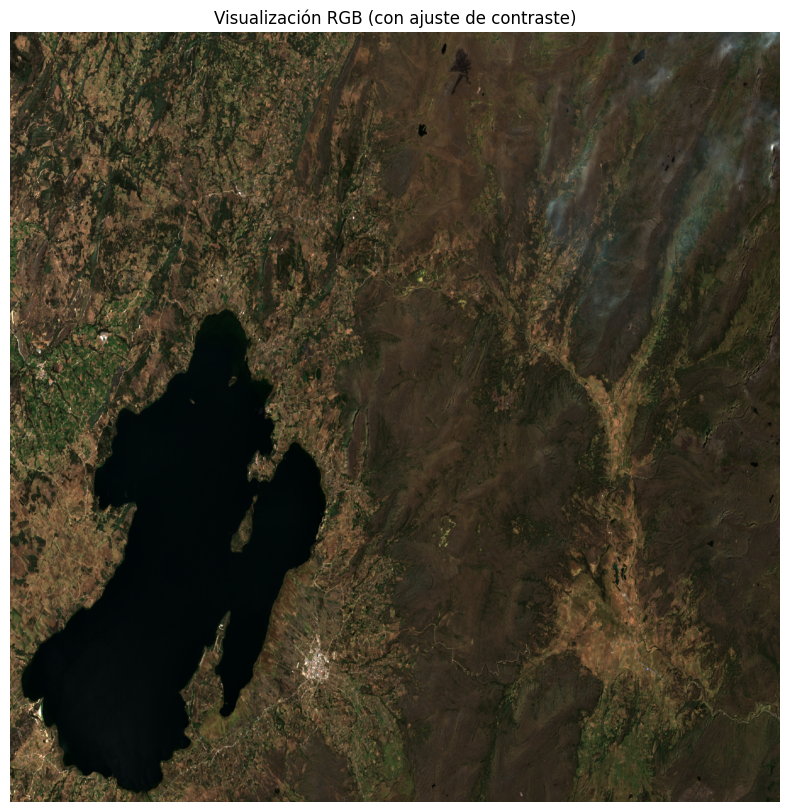

In [5]:
red = src.read(5)  # Banda 4 (Rojo)
green = src.read(4)  # Banda 3 (Verde)
blue = src.read(3)  # Banda 2 (Azul)

# Reemplazar valores no válidos (NaN o infinitos) por 0
red = np.nan_to_num(red, nan=0, posinf=0, neginf=0)
green = np.nan_to_num(green, nan=0, posinf=0, neginf=0)
blue = np.nan_to_num(blue, nan=0, posinf=0, neginf=0)

# Ajuste de contraste: Clipping a un rango adecuado para imágenes Sentinel-2
red = np.clip(red, 0, 0.3)
green = np.clip(green, 0, 0.3)
blue = np.clip(blue, 0, 0.3)

# Normalizar al rango [0, 255] y convertir a uint8
red = ((red / 0.3) * 255).astype(np.uint8)
green = ((green / 0.3) * 255).astype(np.uint8)
blue = ((blue / 0.3) * 255).astype(np.uint8)

# Crear una imagen RGB combinando las bandas
rgb_image = np.dstack((red, green, blue))

# Mostrar la imagen en RGB
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis('off')
plt.title("Visualización RGB (con ajuste de contraste)")
plt.show()

### NDWI

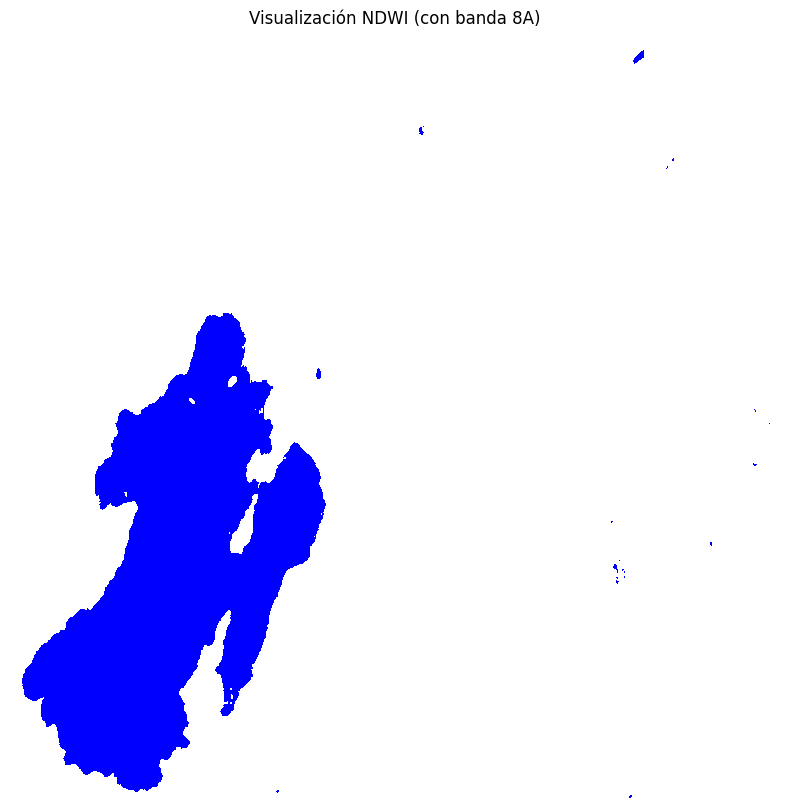

In [6]:
band1 = src.read(15)

# Colores para valores negativos y positivos
cmap = ListedColormap(["white", "blue"])

# Mostrar la banda en la escala especificada
plt.figure(figsize=(10, 10))
plt.imshow(band1, cmap=cmap, vmin=-1, vmax=1)
plt.title("Visualización NDWI (con banda 8A)")
plt.axis('off')  # Opcional: Ocultar los ejes
plt.show()

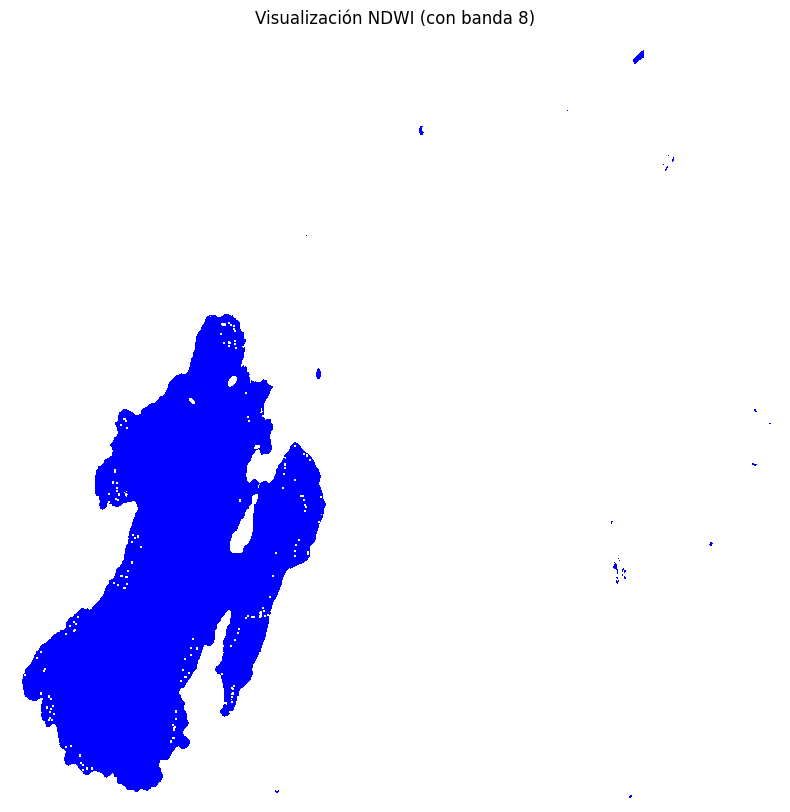

In [7]:
band1 = src.read(14)

# Colores para valores negativos y positivos
cmap = ListedColormap(["white", "blue"])

# Mostrar la banda en la escala especificada
plt.figure(figsize=(10, 10))
plt.imshow(band1, cmap=cmap, vmin=-1, vmax=1)
plt.title("Visualización NDWI (con banda 8)")
plt.axis('off')  # Opcional: Ocultar los ejes
plt.show()

### Areas etiquetadas

In [8]:
etiquetas = src.read(1)

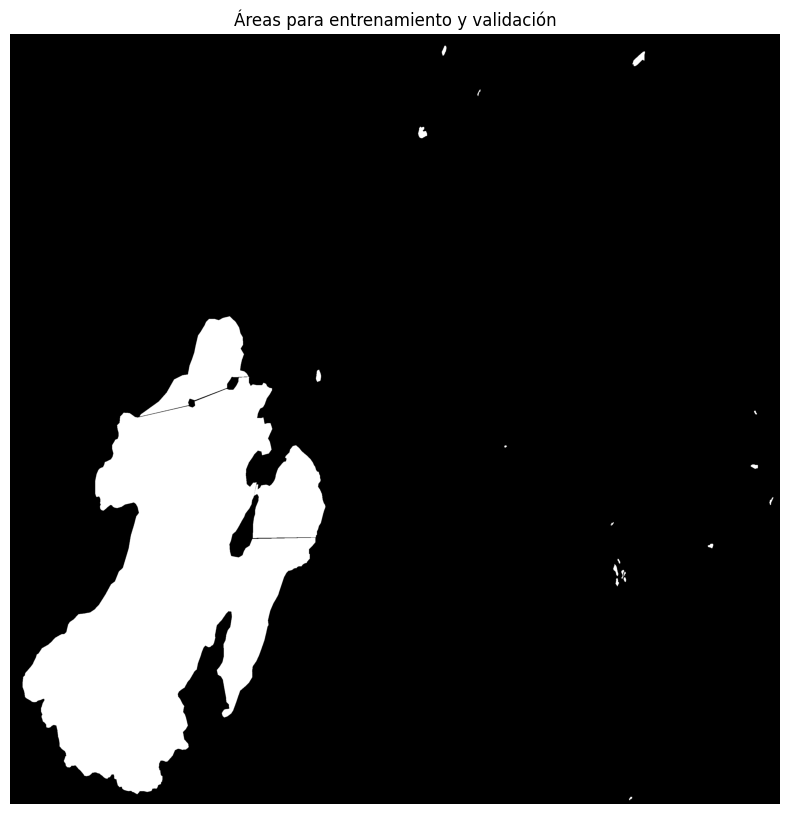

In [9]:
# Asignar un valor constante a todos los valores diferentes de 0
etiquetas_ = np.where(etiquetas > 0, 1, etiquetas)
# Visualizar la banda modificada en escala de grises
plt.figure(figsize=(10, 10))
plt.imshow(etiquetas_, cmap='gray')
plt.title("Áreas para entrenamiento y validación")
plt.axis('off')  # Opcional: Ocultar los ejes
plt.show()

Banda 2 (Áreas para entrenamiento y validación) - Min: 1.0, Max: 24.0, Mean: 2.0781357288360596


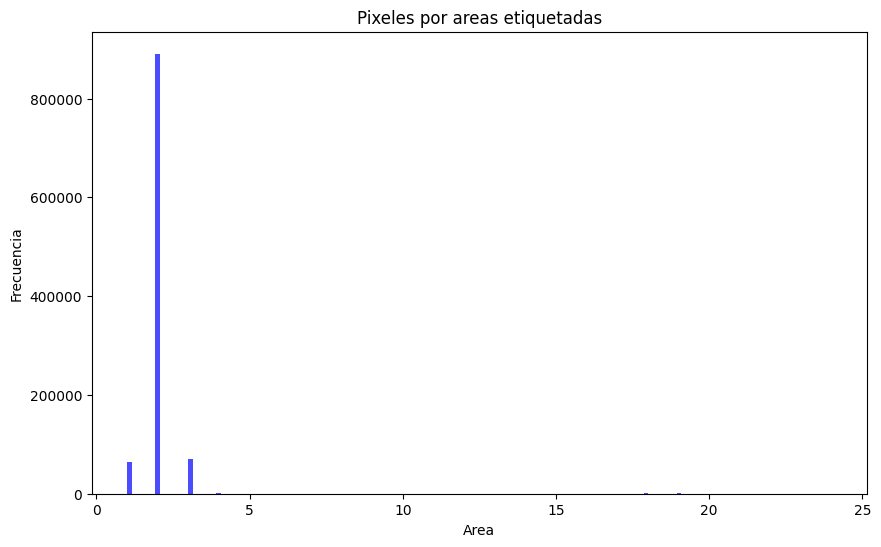

In [10]:
band2_nonzero = etiquetas[etiquetas != 0]
# Calcular estadísticas básicas para la última banda
min_value = np.min(band2_nonzero)
max_value = np.max(band2_nonzero)
mean_value = np.mean(band2_nonzero)

# Imprimir estadísticas
print(f"Banda 2 (Áreas para entrenamiento y validación) - Min: {min_value}, Max: {max_value}, Mean: {mean_value}")

# Crear histograma para la última banda
plt.figure(figsize=(10, 6))
plt.hist(band2_nonzero.flatten(), bins=150, color='blue', alpha=0.7)
plt.title(f'Pixeles por areas etiquetadas')
plt.xlabel('Area')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

## Preparación de los datos

In [11]:
ndwi_8 = src.read(14).flatten()  # NDWI banda 3 y 8
ndwi_8A = src.read(15).flatten()  # NDWI banda 3 y 8A
nir = src.read(9).flatten()  # Infrarrojo cercano
labels = src.read(1).flatten()  # Áreas de interés (etiquetas)

In [12]:
# Crear un DataFrame con las características y las etiquetas
df = pd.DataFrame({
    'NDWI_8': ndwi_8,
    'NDWI_8A': ndwi_8A,
    'NIR': nir,
    'cuerpo_agua': labels
})

In [13]:
df

,NDWI_8,NDWI_8A,NIR,cuerpo_agua
0,-0.704647,-0.667313,0.2476,0.0
1,-0.664408,-0.672501,0.2088,0.0
2,-0.640212,-0.660989,0.1860,0.0
3,-0.640212,-0.660989,0.1860,0.0
4,-0.725916,-0.736751,0.1908,0.0
...,...,...,...,...
8999995,-0.659259,-0.675167,0.2016,0.0
8999996,-0.681649,-0.698202,0.2039,0.0
8999997,-0.681649,-0.698202,0.2039,0.0
8999998,-0.677365,-0.700861,0.1986,0.0


In [14]:
df['cuerpo_agua'] = np.where(df['cuerpo_agua'] > 0, True, False)

In [15]:
df.head()

,NDWI_8,NDWI_8A,NIR,cuerpo_agua
0,-0.704647,-0.667313,0.2476,False
1,-0.664408,-0.672501,0.2088,False
2,-0.640212,-0.660989,0.1860,False
3,-0.640212,-0.660989,0.1860,False
4,-0.725916,-0.736751,0.1908,False


## Estadistica descriptiva

In [21]:
df.describe(percentiles=[0.01,.03,.05,.07,.08,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99])

,NDWI_8,NDWI_8A,NIR
count,8.999674e+06,8.999993e+06,8.999688e+06
mean,-3.923511e-01,-4.143899e-01,1.974972e-01
std,4.861583e-01,4.980826e-01,9.940402e-02
min,-1.229996e+02,-1.430002e+02,-9.990000e-02
1%,-7.403367e-01,-7.568766e-01,-6.000000e-04
3%,-7.052423e-01,-7.220438e-01,1.200000e-03
5%,-6.842105e-01,-7.020921e-01,2.100000e-03
7%,-6.681223e-01,-6.869469e-01,2.700000e-03
8%,-6.611803e-01,-6.804793e-01,3.000000e-03
10%,-6.488550e-01,-6.688851e-01,5.300000e-03


## Datos de entrenamiento y validación